In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import json
import os
import sys

from tqdm import tqdm
src_dir = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'src')
sys.path.append(src_dir)

import traceback

In [2]:
def remove_specific_leading_chars(input_string):
    import re
    # Remove leading commas
    input_string = re.sub(r'^,+', '', input_string)
    # Remove numbers followed by a comma
    return re.sub(r'^\d+,+', '', input_string)

## Toy test comparing CP to CRC formulation

In [3]:
## LTT util functions
import numpy as np
from scipy.stats import binom, norm
from scipy.optimize import brentq
# from confseq import betting
import pdb

def h1(y, mu):
    return y*np.log(y/mu) + (1-y)*np.log((1-y)/(1-mu))

def h2(y):
    return (1+y)*np.log(1+y) - y

### Log tail inequalities of mean
def hoeffding_plus(mu, x, n):
    return -n * h1(np.maximum(mu,x),mu)

def hoeffding_minus(mu, x, n):
    return -n * h1(np.minimum(mu,x),mu)

def bentkus_plus(mu, x, n):
    return np.log(max(binom.cdf(np.floor(n*x),n,mu),1e-10))+1

def bentkus_minus(mu, x, n):
    return np.log(max(binom.cdf(np.ceil(n*x),n,mu),1e-10))+1

def binom_p_value(r_hat,n,alpha):
    return binom.cdf(np.ceil(n*r_hat),n,alpha)

def hb_p_value(r_hat,n,alpha):
    bentkus_p_value = np.e * binom.cdf(np.ceil(n*r_hat),n,alpha)
    def h1(y,mu):
        with np.errstate(divide='ignore'):
            return y * np.log(y/mu) + (1-y) * np.log((1-y)/(1-mu))
    hoeffding_p_value = np.exp(-n*h1(min(r_hat,alpha),alpha))
    return min(bentkus_p_value,hoeffding_p_value)

In [4]:
from typing import List


def score_func(
    claim_scores : List[np.ndarray],
    annotations : List[np.ndarray],
    method : str = "max",
    epsilon : float = 0.1, ## if method == "fraction", largest fraction of allowable unfactual claims
    tau : float = 0.1 ## if method == "fraction_nonmonotone", pre-selected threshold
):
    if method == "max":
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            scores[i] = np.max(cs[~a]) if np.sum(~a) >= 1 else min_score
    if isinstance(method, int):
        ## Think that 'method' here is \lambda in the Cherian et al paper (but tau in that paper is the lambda in loss calibration)
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            ## if (number of untrue claims) > method:
                ## scores[i] = (largest sub-claim score of any False sub-claim)
            ## else:
                ## scores[i] = min_score
            # print((cs, a))
            # if np.sum(~a) > method:
            #     print(f"np.sort(cs[~a])[::-1] : {np.sort(cs[~a])[::-1]}")
            #     print(f"np.sort(cs[~a])[::-1][method] : {np.sort(cs[~a])[::-1][method]}")

            scores[i] = np.sort(cs[~a])[::-1][method] if np.sum(~a) > method else min_score

    if method == "fraction_monotized":
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            sorted_pairs = sorted(zip(cs, a))[::-1]
            # sorted_pairs = np.array(cs_sorted), np.array(a_sorted)
            cs_sorted, a_sorted = zip(*sorted_pairs)
            cs_sorted, a_sorted = np.array(cs_sorted), np.array(a_sorted)
            mono_fraction_arr = np.array([np.mean(a_sorted[:(j+1)]) for j in range(len(a_sorted))]) ## monotized fraction factual
            # print(f"cs_sorted : {cs_sorted}")
            # print(f"a_sorted : {a_sorted}")
            # print(f"mono_fraction_arr : {mono_fraction_arr}")
            # print(f"(1 - mono_fraction_arr) > epsilon : {(1 - mono_fraction_arr) > epsilon}") 
            scores[i] = cs_sorted[(1 - mono_fraction_arr) > epsilon][0] if np.sum((1 - mono_fraction_arr) > epsilon) > 0 else min_score
            # print(f"scores[i] : {scores[i]}")
    
    if method == "fraction_nonmonotone":
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            scores[i] = np.mean(~a[cs >= tau]) if np.sum(cs >= tau) > 0 else min_score

    
    return scores



def loss_factuality(
    claim_scores : List[np.ndarray], ## Float point scores
    annotations : List[np.ndarray], ## Boolean annotations
    tau : float,
    min_score: int = 0
):
    ## Returns 1 if there is some included claim (with score >= tau) that is False
    annotations_included = annotations[claim_scores>=tau]
    return int(max(~annotations_included)) if len(annotations_included) > 0 else min_score


def loss_factuality_fraction(
    claim_scores : List[np.ndarray], ## Float point scores
    annotations : List[np.ndarray], ## Boolean annotations
    tau : float,
    epsilon : float = None,
    min_loss: int = 0
):
    ## Returns 1 if there is some included claim (with score >= tau) that is False
    annotations_included = annotations[claim_scores>=tau]
    if epsilon is None:
        return np.mean(~annotations_included) if len(annotations_included) > 0 else min_loss
    else:
        return int(np.mean(~annotations_included) > epsilon) if len(annotations_included) > 0 else min_loss
        

def loss_factuality_assymetric(
    claim_scores : List[np.ndarray], ## Float point scores
    annotations : List[np.ndarray], ## Boolean annotations
    tau : float,
    epsilon : float = None,
    min_loss: int = 0,
    max_num_subclaims: int = 65
):
    ## Returns 1 if there is some included claim (with score >= tau) that is False
    annotations_included = annotations[claim_scores>=tau]
    if epsilon is None:
        # if len(annotations_included) == 0 or np.sum(~annotations_included) == 0:
        #     ## If null set or all subclaims are true, then return minimum loss
        #     return min_loss
        # elif np.sum(~annotations_included) > 0:
        #     ## If there is at least one untrue subclaim, then loss is number of untrue subclaims
        #     return np.sum(~annotations_included)

        ## Loss is 10*(Num untrue subclaims) - (Num true subclaims)
        return (np.sum(~annotations_included) - np.sum(annotations_included) / 10) / len(annotations_included) if len(annotations_included) > 0 else min_loss
        
    else:
        raise Exception("Threshold epsilon not yet implemented for this loss function")
        # return int(np.mean(~annotations_included) > epsilon) if len(annotations_included) > 0 else min_loss


def loss_factuality_length(
    claim_scores : List[np.ndarray], ## Float point scores
    annotations : List[np.ndarray], ## Boolean annotations
    tau : float,
    epsilon : float = None,
    min_loss: int = 0,
    # max_num_subclaims: int = 
):
    ## Returns 1 if there is some included claim (with score >= tau) that is False
    annotations_included = annotations[claim_scores>=tau]
    if epsilon is None:
        # if len(annotations_included) == 0 or np.sum(~annotations_included) == 0:
        #     ## If null set or all subclaims are true, then return minimum loss
        #     return min_loss
        # elif np.sum(~annotations_included) > 0:
        #     ## If there is at least one untrue subclaim, then loss is number of untrue subclaims
        #     return np.sum(~annotations_included)

        ## Scaling fraction by number of total claims
        if len(annotations_included) == 0:
            return min_loss

        if len(annotations_included) <= 40:
            return np.mean(~annotations_included)

        else:
            return min(1, (np.sum(~annotations_included[:40]) + max(0, len(annotations_included) - 40)) / len(annotations_included))
        
        # return np.mean(~annotations_included) * len(annotations_included) if len(annotations_included) > 0 else min_loss
        
    else:
        raise Exception("Threshold epsilon not yet implemented for this loss function")
        # return int(np.mean(~annotations_included) > epsilon) if len(annotations_included) > 0 else min_loss
        

# def loss_factuality_fraction_tol(
#     claim_scores : List[np.ndarray], ## Float point scores
#     annotations : List[np.ndarray], ## Boolean annotations
#     tau : float,
#     epsilon : float = 0.1,
#     min_loss: int = 0
# ):
#     ## Returns 1 if there is some included claim (with score >= tau) that is False
#     annotations_included = annotations[claim_scores>=tau]
#     return int(np.mean(~annotations_included) > epsilon) if len(annotations_included) > 0 else min_loss
    


n = 100
n_subclaims = 100
alpha = 0.15
epsilon = 0.15
model_probs = [np.random.uniform(size=n_subclaims) for i in range(n)]
subclaim_annotations = [np.random.binomial(n=1, p=model_probs_curr) for model_probs_curr in model_probs]

# print(f"subclaim_annotations : \n {subclaim_annotations}")
# print(f"model_probs : \n {model_probs}")

for i in range(n):
    # Zip the lists together, sort, and unzip
    model_probs_curr, subclaims_curr = model_probs[i], subclaim_annotations[i]
    zipped_pairs = zip(model_probs_curr, subclaims_curr)
    sorted_pairs = sorted(zipped_pairs)[::-1]

    model_probs_curr, subclaims_curr = zip(*sorted_pairs)
    model_probs[i], subclaim_annotations[i] = np.array(model_probs_curr), np.array(subclaims_curr).astype(bool)


# print(f"subclaim_annotations sorted : \n {subclaim_annotations}")

# print(f"model_probs sorted : \n {model_probs}")


nonconformity_scores = score_func(model_probs, subclaim_annotations, method=0)
# print(f"nonconformity_scores : {nonconformity_scores}")
nonconformity_scores_sorted = np.array(sorted(nonconformity_scores))
ind_q = (np.ceil((1-alpha)*(n+1))).astype(int)
# print(f"ind_q : {ind_q}")
# print(f"nonconformity_scores_sorted : {nonconformity_scores_sorted}")
print(f"fitted tau (strict) : {nonconformity_scores_sorted[ind_q - 1]}")

##
nc_scores_frac_mono = score_func(model_probs, subclaim_annotations, method="fraction_monotized", epsilon = epsilon)
nc_scores_frac_mono_sorted = np.array(sorted(nc_scores_frac_mono))
ind_q = (np.ceil((1-alpha)*(n+1))).astype(int)
# print(f"nc_scores_frac_mono : {nc_scores_frac_mono}")
print(f"fitted tau (monotized fraction) {nc_scores_frac_mono_sorted[ind_q - 1]}")


import sys

def rc_frac_factuality(claim_scores : List[np.ndarray],
                         annotations : List[np.ndarray],
                         taus_to_search,
                         epsilon,
                         alpha,
                         method_name = "gcrc", ## "gcrc", "monotized_losses_crc", "standard_crc", "ltt"
                         small_num_adjust = 1e-10,
                         n_grid = 200, ## Number of threshold to search,
                         B = 1, ## Maximum loss
                         loss_name = "loss_factuality_fraction"
                        ):

    if (len(claim_scores) != len(annotations)):
        raise Exception(f"len(claim_scores) = {len(claim_scores)} != {len(annotations)} = len(annotations)")

    n = len(claim_scores)


    taus_to_search = np.unique(taus_to_search)[::-1] + small_num_adjust ## Sort descending (safest to most aggressive)
    num_taus_unique = len(taus_to_search)
    k = max(int(num_taus_unique / n_grid), 1)
    # print(f"len all taus : {len(taus_to_search)}")
    
    taus_to_search = taus_to_search[::k]
    # print(f"len subset taus : {len(taus_to_search)}")

    # print(f"taus_to_search : {taus_to_search}")
         
    risk_prev = 0.0
    tau_prev = 1.0 + 1e-10

    if taus_to_search[0] < 1.0:
        ## Make sure to include safe tau value
        taus_to_search = np.concatenate(([1.0], taus_to_search))

    if method_name == "standard_crc":
        ## Standard CRC implemented by searching from most-aggressive (smallest) hyperparameter to safest (largest)
        taus_to_search = taus_to_search[::-1]
    
    losses = np.zeros(n+1)
    losses[n] = B ## Conservative loss for test point
    risks = [risk_prev]
    
    for t, tau in enumerate((taus_to_search)):
        
        for i in range(n):
            if method_name in ["gcrc", "standard_crc", "ltt"] or method_name == "monotized_losses_crc" and t == 0:
                losses[i] = eval(loss_name)(claim_scores[i], annotations[i], tau, epsilon = epsilon)
            
            elif method_name == "monotized_losses_crc" and t > 0:
                ## If running monotized-losses CRC (Corollary 1 in Angelopoulos et al. (2024), loss is maximum seen so far for that point)
                losses[i] = max(losses[i], eval(loss_name)(claim_scores[i], annotations[i], tau, epsilon = epsilon))

            else:
                raise Exception(f"method_name '{method_name}' not recognized!")
                

        if method_name == "ltt":
            ## For LTT, no conservative "test point loss"
            risk_curr = losses[:n].mean()
            p_val_curr = hb_p_value(risk_curr, n, alpha)
            
        else:
            risk_curr = losses.mean()

        risks.append(risk_curr)

        if method_name in ["gcrc", "monotized_losses_crc"] and risk_curr > alpha:
            ## Stopping condition for GCRC and monotized-losses CRC methods, return most recent tau prior to current
            break

        elif method_name == "ltt" and p_val_curr > alpha:
            ## Stopping condition for LTT is based on calculated p-value
            break
            
        elif method_name == "standard_crc" and risk_curr <= alpha:
            ## Stopping condition for standard CRC: return first identified safe hyperparam
            return tau, losses.mean(), risks
        
        else:
            risk_prev = risk_curr
            tau_prev = tau

    # print(f"selected tau : {tau_prev}")
    return tau_prev, risk_prev, risks


# tau_strict, risk_strict = rc_frac_factuality(claim_scores=model_probs, annotations=subclaim_annotations, taus_to_search=nonconformity_scores, epsilon = 0.0, alpha = alpha)
tau_frac_gcrc, risk_frac_gcrc, risks_gcrc = rc_frac_factuality(claim_scores=model_probs, annotations=subclaim_annotations, taus_to_search=nonconformity_scores, epsilon = epsilon, alpha = alpha, method_name = "gcrc")
tau_frac_mono, risk_frac_mono, risks_mono = rc_frac_factuality(claim_scores=model_probs, annotations=subclaim_annotations, taus_to_search=nonconformity_scores, epsilon = epsilon, alpha = alpha, method_name = "monotized_losses_crc")


# print(f" GCRC tau strict factuality   : \n tau_strict={tau_strict}, risk_strict={risk_strict} \n")
print(f" Monotized-CRC tau fraction factuality : \n tau_frac={tau_frac_mono}, risk_frac={risk_frac_mono}\n")
print(f" GCRC tau fraction factuality          : \n tau_frac={tau_frac_gcrc}, risk_frac={risk_frac_gcrc}\n")


# nc_scores_nonmono_frac = score_func(claim_scores=model_probs, annotations=subclaim_annotations, method="fraction_nonmonotone", epsilon=epsilon, tau=tau_frac)
# nc_scores_nonmono_frac = np.array(sorted(nc_scores_nonmono_frac))
# ind_q = (np.ceil((1-alpha)*(n+1))).astype(int)
# print(f"nonmonotone scores : {nc_scores_nonmono_frac}")
# print(f"nc_scores_nonmono_frac : {nc_scores_nonmono_frac[ind_q - 1]}")


fitted tau (strict) : 0.9414511370342087
fitted tau (monotized fraction) 0.9398255696394078
 Monotized-CRC tau fraction factuality : 
 tau_frac=0.9376662703090379, risk_frac=0.1485148514851485

 GCRC tau fraction factuality          : 
 tau_frac=0.8356644503802473, risk_frac=0.13861386138613863



In [5]:
1.0 + sys.float_info.min

1.0

In [6]:
a = [0, 1, 2, -10, 3, -2, 4, 4, 1]
np.unique(a)

array([-10,  -2,   0,   1,   2,   3,   4])

## Load dataset and features from saved files

In [7]:
remove_easy_data = False

## Loading datasets
orig_datasets = {}
suffix = '.jsonl'
dataset_dir = "/home/drewprinster/conformal-safety/data/MedLFQAv2" #"/Users/cherian/Projects/conformal-safety/data/MedLFQAv2"
for path in os.listdir(dataset_dir):
    dataset_name = path[:-len(suffix)]
    if not path.startswith('.'):
        with open(os.path.join(dataset_dir, path), 'r') as fp:
            orig_datasets[dataset_name] = [json.loads(line) for line in fp.readlines()]

## Dictionary where can search using quesiton and get name of original dataset it came from
dataset_lookup = {}
for name, data in orig_datasets.items():
    for dat in data:
        dataset_lookup[dat['Question']] = name

## Getting scores
data_path = "/home/drewprinster/conformal-safety/data" #"/Users/cherian/Projects/conformal-safety/data"
dataset_path = os.path.join(data_path, "medlfqa_dataset.pkl")
freq_path = os.path.join(data_path, "medlfqa_frequencies.npz")
logprob_path = os.path.join(data_path, "medlfqa_logprobs.npz")
selfeval_path = os.path.join(data_path, "medlfqa_selfevals.npz")

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)


## HARD CODED FIX FOR REDUNDANT PROMPT...which has atomic_facts assigned to the wrong redundancy
dataset[1132]['atomic_facts'] = dataset[1048]['atomic_facts']


frequencies = np.load(freq_path)
logprobs = np.load(logprob_path)
selfevals = np.load(selfeval_path)

drop_prompts = []
for k in frequencies:
    if frequencies[k].ndim != 1:
        drop_prompts.append(k)
    elif np.allclose(selfevals[k], -1):
        drop_prompts.append(k)
    elif k not in logprobs:
        drop_prompts.append(k)
    elif remove_specific_leading_chars(k).strip() not in dataset_lookup:
        drop_prompts.append(k)

# drop and match ordering of dataset
dataset = [dat for dat in dataset if dat['prompt'] not in drop_prompts] ## List where each entry is a dictionary with 'prompt', 'response', and 'atomic_facts'
full_dataset = dataset
prompts_to_keep = [dat['prompt'] for dat in dataset] ## List where each entry is the full prompt
names_to_keep = [p.split('about')[-1].strip()[:-1] for p in prompts_to_keep] ## List where each entry is an abbreviated prompt for a name

## Lists where each entry in the list is an array of scores for subclaims
frequencies_arr = [frequencies[p] for p in prompts_to_keep] ## Frequency scoring
selfevals_arr = [selfevals[p] for p in prompts_to_keep] ## Self-evaluation scoring
logprobs_arr = [logprobs[p] for p in prompts_to_keep] ## Log-probability scoring
annotations_arr = [np.asarray([af["is_supported"] for af in dat["atomic_facts"]]) for dat in dataset] ## Oracle (annotation) scoring
ordinal_arr = [np.arange(len(f)) for f in frequencies_arr] ## Ordinal scoring (baseline)


## Record maximum subclaim scores

# If removing data where all subclaims are true (for harder benchmark)
if remove_easy_data:
    indicators_all_subclaims_true = []
    for i in range(len(dataset)):
        indicators_all_subclaims_true.append(bool(min([dataset[i]['atomic_facts'][j]['is_supported'] for j in range(len(dataset[i]['atomic_facts']))])))

    dataset = [d for i, d in enumerate(dataset) if indicators_all_subclaims_true[i]]
    full_dataset = dataset
    prompts_to_keep = [dat['prompt'] for dat in dataset] ## List where each entry is the full prompt
    names_to_keep = [p.split('about')[-1].strip()[:-1] for p in prompts_to_keep] ## List where each entry is an abbreviated prompt for a name

    frequencies_arr = [d for i, d in enumerate(frequencies_arr) if indicators_all_subclaims_true[i]] ## Frequency scoring
    selfevals_arr = [d for i, d in enumerate(selfevals_arr) if indicators_all_subclaims_true[i]] ## Self-evaluation scoring
    logprobs_arr = [d for i, d in enumerate(logprobs_arr) if indicators_all_subclaims_true[i]] ## Log-probability scoring
    annotations_arr = [d for i, d in enumerate(annotations_arr) if indicators_all_subclaims_true[i]] ## Oracle (annotation) scoring
    ordinal_arr = [d for i, d in enumerate(ordinal_arr) if indicators_all_subclaims_true[i]] ## Ordinal scoring (baseline)


print(len(frequencies_arr), len(selfevals_arr), len(dataset), len(annotations_arr))


4805 4805 4805 4805


In [226]:
indicators_all_subclaims_true = []
for i in range(len(dataset)):
    indicators_all_subclaims_true.append(min([dataset[i]['atomic_facts'][j]['is_supported'] for j in range(len(dataset[i]['atomic_facts']))]))
np.sum(indicators_all_subclaims_true) / len(indicators_all_subclaims_true)
len(dataset)
len([d for i, d in enumerate(dataset) if indicators_all_subclaims_true[i]])



2505

max len : 65


np.float64(16.898231009365244)

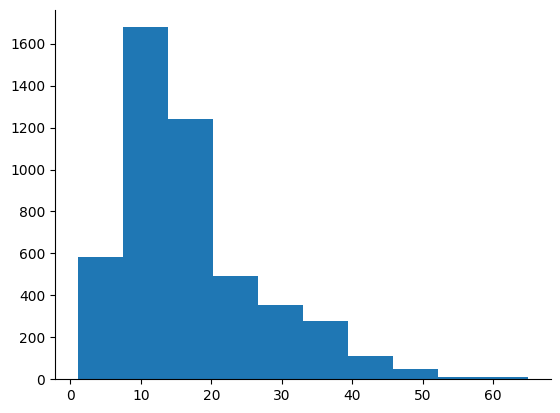

In [227]:
max_len = 0
all_lens = []
for f_arr in frequencies_arr:
    all_lens.append(len(f_arr))
    if len(f_arr) > max_len:
        max_len = len(f_arr)
print(f"max len : {max_len}")
plt.hist(all_lens)
np.mean(all_lens)



In [8]:
# get prompt-level features

# names of datasets
dataset_arr = [dataset_lookup[remove_specific_leading_chars(p).strip()] for p in prompts_to_keep] ## List of original dataset name for each question
dataset_dummies = pd.get_dummies(dataset_arr) ## Pandas dataframe with dummies indicating dataset origin name for each question
dataset_names = [name[:-3] if name.endswith("_qa") else name for name in dataset_dummies.columns] ## Unique list of (five) dataset names

# length of response
response_len_arr = [len(dat['response']) for dat in dataset]
response_len_arr = np.asarray(response_len_arr).reshape(-1,1) ## Array where each entry is the string length of the response to each question

# length of prompt
prompt_len_arr = [len(remove_specific_leading_chars(dat['prompt']).strip()) for dat in dataset]
prompt_len_arr = np.asarray(prompt_len_arr).reshape(-1,1) ## Array where each entry is the string length of the prompt/question

# mean (exponentiated) logprob 
logprobs_mean_arr = [np.mean(arr) for arr in logprobs_arr]
logprobs_mean_arr = np.asarray(logprobs_mean_arr).reshape(-1,1) ## Array where each entry is the mean log-probability (over subclaims) for each response

# std (exponentiated) logprob
logprobs_std_arr = [np.std(arr) for arr in logprobs_arr]
logprobs_std_arr = np.asarray(logprobs_std_arr).reshape(-1,1) ## Array where each entry is the std log-probability (over subclaims) for each response

z_ones = np.ones((len(frequencies_arr), 1)) ## Array of ones equal in length to dataset
z_arr = np.concatenate((z_ones, response_len_arr, prompt_len_arr, logprobs_mean_arr, logprobs_std_arr), axis=1)
z_dummies = dataset_dummies.to_numpy()

## Array of features computed using prompt and response (X_i) in paper
## Cols: (0) ones, (1) response len, (2) prompt len, (3) mean log-prob over subclaims, (4) std log-prob over subclaims
## (5, 6, 7, 8) indicators for 4 of 5 datasets (last one is indicated by first 4 being false)
z_arr_dummies = np.concatenate((z_arr, z_dummies[:,:-1]), axis=1) 

print(len(dataset_arr), len(response_len_arr), len(prompt_len_arr), len(logprobs_mean_arr), len(logprobs_std_arr))
dataset_dummies

4805 4805 4805 4805 4805


,healthsearch_qa,kqa_golden,kqa_silver_wogold,live_qa,medication_qa
0,True,False,False,False,False
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
4800,True,False,False,False,False
4801,False,False,False,False,True
4802,True,False,False,False,False
4803,False,False,False,False,True


In [9]:
from typing import List
# from conditionalconformal import CondConf
from condconf import CondConf

def split_dataset(dataset, rng, train_frac = 0.8, train_num = None):
    x, y = dataset
    ind = np.arange(len(x))
    rng.shuffle(ind)
    if train_num is None:
        ## Providing train_num as argument overrules train_frac (else train_frac determines train_num)
        train_num = int(train_frac * len(x))
    train_ind = ind[0:train_num]
    calib_ind = ind[train_num:]

    x_train = [x[i] for i in train_ind]
    y_train = [y[i] for i in train_ind]

    x_calib = [x[i] for i in calib_ind]
    y_calib = [y[i] for i in calib_ind]

    return (x_train, y_train), (x_calib, y_calib), train_ind, calib_ind
    
def score_func(
    claim_scores : List[np.ndarray],
    annotations : List[np.ndarray],
    method : str = "max"
):
    if method == "max":
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            scores[i] = np.max(cs[~a]) if np.sum(~a) >= 1 else min_score
    if isinstance(method, int):
        ## Think that 'method' here is \lambda in the Cherian et al paper (but tau in that paper is the lambda in loss calibration)
        min_score = -1
        scores = np.zeros((len(claim_scores),))
        for i, (cs, a) in enumerate(zip(claim_scores, annotations)):
            ## if (number of untrue claims) > method:
                ## scores[i] = (largest sub-claim score of any False sub-claim)
            ## else:
                ## scores[i] = min_score
            # print((cs, a))
            # if np.sum(~a) > method:
            #     print(f"np.sort(cs[~a])[::-1] : {np.sort(cs[~a])[::-1]}")
            #     print(f"np.sort(cs[~a])[::-1][method] : {np.sort(cs[~a])[::-1][method]}")

            scores[i] = np.sort(cs[~a])[::-1][method] if np.sum(~a) > method else min_score
    return scores

def split_threshold(
    conf_scores : np.ndarray,
    quantile
):
    n = len(conf_scores)
    threshold = np.sort(conf_scores)[int(np.ceil(quantile * (n + 1)))]
    return threshold

def get_frac_true_claims_retained(claim_scores, annotations, thresholds):
    recall = []
    for cs, a, t in zip(claim_scores, annotations, thresholds):
        frac = np.sum((cs > t) & a) / np.sum(a) if np.sum(a) > 0 else 0
        recall.append(frac)
    return recall

def get_retained_claims(claim_scores, thresholds):
    claims_retained = []
    for cs, t in zip(claim_scores, thresholds):
        claims_retained.append(np.mean(cs > t))
    return claims_retained

def get_retained_claim_indices(claim_scores, thresholds):
    claims_retained = []
    for cs, t in zip(claim_scores, thresholds):
        claims_retained.append(np.where(cs > t)[0])
    return claims_retained

def get_validity(claim_scores, annotations, threshold, method):
    conf_scores = score_func(claim_scores, annotations, method)
    validity = conf_scores <= threshold
    return validity

def run_split_conformal(x_arr, y_arr, method, quantile):
    conf_scores = score_func(x_arr, y_arr, method=k)
    threshold = split_threshold(conf_scores, quantile)
    return conf_scores, threshold


In [10]:
a = np.array([True, False, True])
b = np.array([True, True, False])
a & b

array([ True, False, False])

In [11]:
rng = np.random.default_rng(seed=0)
rand_scores = rng.standard_normal(size=(len(np.concatenate(selfevals_arr)),))

print(np.corrcoef(np.concatenate(frequencies_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(np.concatenate(logprobs_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(np.concatenate(selfevals_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(np.concatenate(ordinal_arr), np.concatenate(annotations_arr)))
print(np.corrcoef(rand_scores, np.concatenate(annotations_arr)))

[[1.         0.29924037]
 [0.29924037 1.        ]]
[[1.        0.3700479]
 [0.3700479 1.       ]]
[[1.         0.16687224]
 [0.16687224 1.        ]]
[[1.         0.03922197]
 [0.03922197 1.        ]]
[[ 1.         -0.00389273]
 [-0.00389273  1.        ]]


In [12]:
BLUE = '#2166ac'           # β̂ vertical line
TEAL = '#5ab4ac'           # Calibration data (complements blue/red)
RED = '#d73027'            # Test point (conservative/warning)

def empirical_cdf(
    values, ## numpy array with values
    x ## value to evaluate empirical CDF at
) -> float:
    return len(values[values <= x])/len(values)


def get_taus_grid_from_data(claim_scores : List ## List of arrays of subclaim scores
                           ):
    taus_set = []
    for i, cs in enumerate(claim_scores):
        taus_set.extend(cs)
        
    return np.array(taus_set)


def run_crc_trial(x_arr, ## List where each entry is an array of sub-claim scores for a response
                  y_arr, ## List where each entry is an array of sub-claim "oracle scores" or annotations
                  z_arr, ## List of features for the prompt and response used for conditional calibration (all ones for marginal cp)
                  rng, method_name, alpha, epsilon, loss_name = "loss_factuality_fraction", cal_frac = 0.7):

    data_calib, data_test, idx_calib, idx_test = split_dataset((x_arr, y_arr), rng, train_frac=cal_frac) ## here "train_frac" is actually for cal
    # print(data_calib[0])
    # print(f"num cal : {len(data_calib[0])}")
    # scores_calib = score_func(*data_calib, method=method) ## Calibration set nonconformity scores
    # scores_test = score_func(*data_test, method=method) ## Test set nonconformity scores

    # print(data_calib)
    taus_to_search = get_taus_grid_from_data(data_calib[0])
    
    
    threshold, _, risks = rc_frac_factuality(*data_calib, taus_to_search=taus_to_search, epsilon=epsilon, alpha=alpha, \
                                             method_name=method_name, loss_name = loss_name) ## "gcrc", "monotized_losses_crc",
    # valid_inds = []
    constraint_violations = []
    claim_perc = []

    

    for i, j in enumerate(idx_test):
        loss = eval(loss_name)(data_test[0][i], data_test[1][i], tau=threshold, epsilon=epsilon)
        
        # valid_inds.append(threshold >= scores_test[i])
        constraint_violations.append(loss)
        claim_perc.append(get_frac_true_claims_retained([data_test[0][i]], [data_test[1][i]], [threshold])[0])
                          
    # valid_inds = np.asarray(valid_inds).flatten()
    constraint_violations = np.asarray(constraint_violations).flatten()
    claim_perc = np.asarray(claim_perc).flatten()

    return np.mean(constraint_violations), np.mean(claim_perc), risks

    # all_covs = np.zeros((1,))
    # marginal_cov = np.mean(constraint_violations)
    # all_covs[0] = marginal_cov

    # all_claims = np.zeros((1,))
    # all_claims[0] = np.mean(claim_perc)

    # dataset_covs = np.zeros(len(dataset_names))
    # dataset_claims = np.zeros(len(dataset_names))

    # for d_idx in range(len(dataset_names)):
    #     dataset_cov = np.sum(dataset_dummies.to_numpy()[idx_test,d_idx] * constraint_violations) / np.sum(dataset_dummies.to_numpy()[idx_test,d_idx])
    #     dataset_covs[d_idx] = dataset_cov
    #     dataset_perc = np.sum(dataset_dummies.to_numpy()[idx_test,d_idx] * claim_perc) / np.sum(dataset_dummies.to_numpy()[idx_test,d_idx])
    #     dataset_claims[d_idx] = dataset_perc

    # return np.concatenate((all_covs, dataset_covs)), np.concatenate((all_claims, dataset_claims))


def run_coverage_trial(x_arr, ## List where each entry is an array of sub-claim scores for a response
                       y_arr, ## List where each entry is an array of sub-claim "oracle scores" or annotations
                       z_arr, ## List of features for the prompt and response used for conditional calibration (all ones for marginal cp)
                       rng, method, quantile):
    data_calib, data_test, idx_calib, idx_test = split_dataset((x_arr, y_arr), rng, train_frac=0.7)
    print(f"data_calib : {data_calib[0][0]}, {data_calib[1][0]}")
    scores_calib = score_func(*data_calib, method=method) ## Calibration set nonconformity scores
    scores_test = score_func(*data_test, method=method) ## Test set nonconformity scores
    
    print(f"cal_test : {len(scores_calib)}")

    print(f"scores_test : {len(scores_test)}")
    
    condconf = CondConf(lambda x,y: y, lambda x: x)
    condconf.setup_problem(z_arr[idx_calib], scores_calib)
    # print(condconf.x_calib)
    # print(condconf.y_calib)
    # print(condconf.scores_calib)
    # print(condconf.cvx_problem)

    
    # scores, threshold = run_split_conformal(*data_calib, method=method, quantile=quantile)
    valid_inds = []
    claim_perc = []
    # print(f"data_test[0] len : {len(data_test[0])}, {data_test[0][0]}")
    # print(f"data_test[1] len : {len(data_test[1])}, {data_test[1][0]}")
    # for i in range(10):
    #     data_concat = np.c_[data_test[0][i], data_test[1][i]]
        
    #     sort_indices = data_concat[:, 0].argsort()
    #     sorted_data = data_concat[sort_indices]
    #     print(f"sorted_data : {sorted_data}")


    # print(f"idx_test : {idx_test}")
    for i, j in enumerate(idx_test):
        # print(z_arr[j].reshape(1,-1))
        try:
            threshold = condconf.predict(quantile, z_arr[j].reshape(1,-1), lambda c, x: c, randomize=True) # S_min=-1, S_max=1,
        except Exception as e:
            # print(f"An exception occurred: {e}") 
            # traceback.print_exc()
            threshold = [np.inf]
            # threshold = [1]
        # print(f"threshold : {threshold}, scores_test[i] : {scores_test[i]}")
        valid_inds.append(threshold >= scores_test[i])
        claim_perc.append(get_retained_claims([data_test[0][i]], threshold)[0])
                          
    valid_inds = np.asarray(valid_inds).flatten()
    claim_perc = np.asarray(claim_perc).flatten()

    # valid_inds = get_validity(*data_calib, threshold, method)
    all_covs = np.zeros((1,))
    marginal_cov = np.mean(valid_inds)
    all_covs[0] = marginal_cov

    all_claims = np.zeros((1,))
    all_claims[0] = np.mean(claim_perc)

    dataset_covs = np.zeros(len(dataset_names))
    dataset_claims = np.zeros(len(dataset_names))

    for d_idx in range(len(dataset_names)):
        dataset_cov = np.sum(dataset_dummies.to_numpy()[idx_test,d_idx] * valid_inds) / np.sum(dataset_dummies.to_numpy()[idx_test,d_idx])
        dataset_covs[d_idx] = dataset_cov
        dataset_perc = np.sum(dataset_dummies.to_numpy()[idx_test,d_idx] * claim_perc) / np.sum(dataset_dummies.to_numpy()[idx_test,d_idx])
        dataset_claims[d_idx] = dataset_perc
    
    return np.concatenate((all_covs, dataset_covs)), np.concatenate((all_claims, dataset_claims))

In [267]:
np.arange(0.005, 0.065, 0.01)

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055])

[0.005 0.03 ]
Running experiments for logprobs scoring...
monotized_losses_crc


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


ltt


  0%|                                                     | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_1196013/603065174.py:34: RuntimeWarning: invalid value encountered in scalar multiply
  return y * np.log(y/mu) + (1-y) * np.log((1-y)/(1-mu))
100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.72s/it]


gcrc


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.53s/it]


{'monotized_losses_crc':    alphas  risk_mean  risk_std
 0   0.005   0.003941       0.0
 1   0.030   0.015247       0.0,
 'ltt':    alphas  risk_mean  risk_std
 0   0.005   0.003121       0.0
 1   0.030   0.022969       0.0,
 'gcrc':    alphas  risk_mean  risk_std
 0   0.005   0.004166       0.0
 1   0.030   0.030307       0.0}

{'monotized_losses_crc':    alphas  claims_mean  claims_std
 0   0.005     0.076071         0.0
 1   0.030     0.670678         0.0,
 'ltt':    alphas  claims_mean  claims_std
 0   0.005     0.023159         0.0
 1   0.030     0.837039         0.0,
 'gcrc':    alphas  claims_mean  claims_std
 0   0.005     0.083123         0.0
 1   0.030     0.910293         0.0}

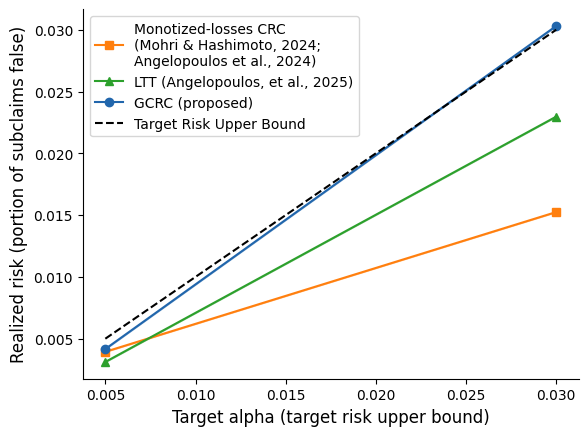

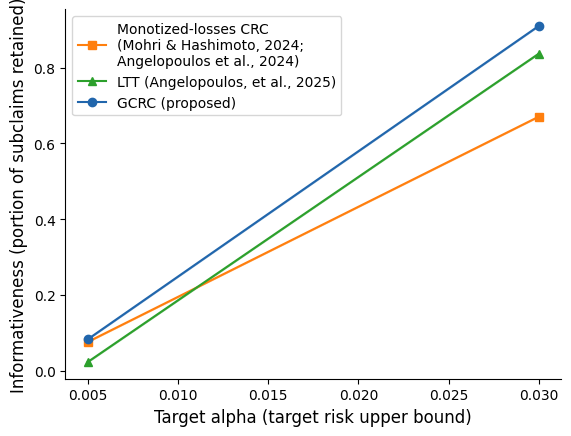

Running experiments for frequency scoring...
monotized_losses_crc


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.33s/it]


ltt


  0%|                                                     | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_1196013/603065174.py:34: RuntimeWarning: invalid value encountered in scalar multiply
  return y * np.log(y/mu) + (1-y) * np.log((1-y)/(1-mu))
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


gcrc


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.15s/it]


{'monotized_losses_crc':    alphas  risk_mean  risk_std
 0   0.005   0.000000       0.0
 1   0.030   0.028947       0.0,
 'ltt':    alphas  risk_mean  risk_std
 0   0.005        0.0       0.0
 1   0.030        0.0       0.0,
 'gcrc':    alphas  risk_mean  risk_std
 0   0.005   0.000000       0.0
 1   0.030   0.028947       0.0}

{'monotized_losses_crc':    alphas  claims_mean  claims_std
 0   0.005     0.000000         0.0
 1   0.030     0.813126         0.0,
 'ltt':    alphas  claims_mean  claims_std
 0   0.005          0.0         0.0
 1   0.030          0.0         0.0,
 'gcrc':    alphas  claims_mean  claims_std
 0   0.005     0.000000         0.0
 1   0.030     0.813126         0.0}

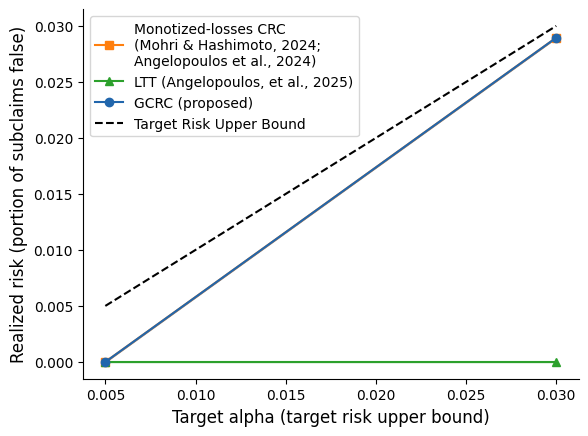

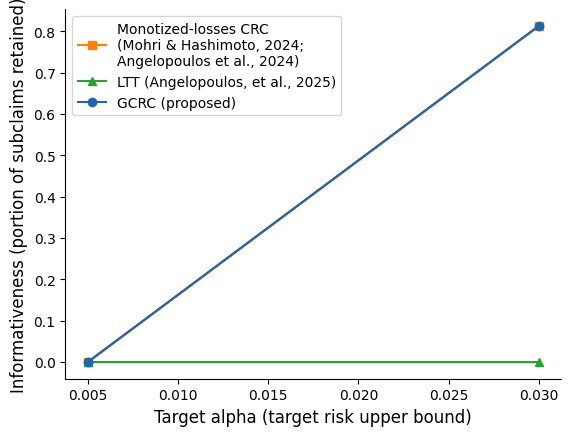

Running experiments for selfevals scoring...
monotized_losses_crc


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


ltt


  0%|                                                     | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_1196013/603065174.py:34: RuntimeWarning: invalid value encountered in scalar multiply
  return y * np.log(y/mu) + (1-y) * np.log((1-y)/(1-mu))
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


gcrc


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


{'monotized_losses_crc':    alphas  risk_mean  risk_std
 0   0.005   0.001445       0.0
 1   0.030   0.001445       0.0,
 'ltt':    alphas  risk_mean  risk_std
 0   0.005   0.001081       0.0
 1   0.030   0.001445       0.0,
 'gcrc':    alphas  risk_mean  risk_std
 0   0.005   0.001445       0.0
 1   0.030   0.001445       0.0}

{'monotized_losses_crc':    alphas  claims_mean  claims_std
 0   0.005     0.047456         0.0
 1   0.030     0.047456         0.0,
 'ltt':    alphas  claims_mean  claims_std
 0   0.005     0.033331         0.0
 1   0.030     0.047456         0.0,
 'gcrc':    alphas  claims_mean  claims_std
 0   0.005     0.047456         0.0
 1   0.030     0.047456         0.0}

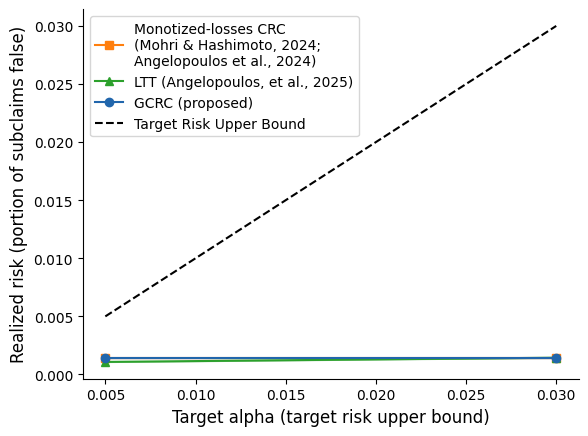

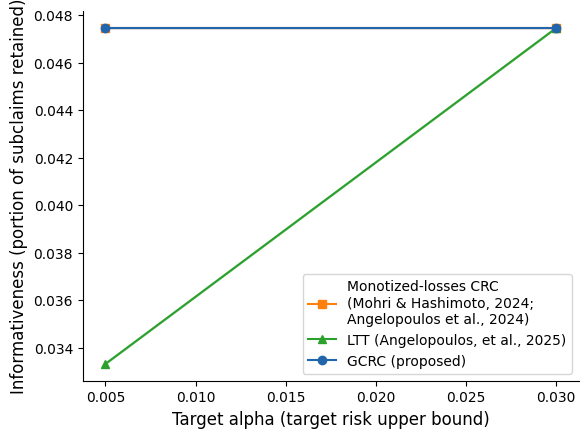

In [268]:

n_trials = 1
# all_covs = np.zeros((n_trials, 1 + len(dataset_names)))
# all_claims = np.zeros((n_trials, 1 + len(dataset_names)))


rng = np.random.default_rng(seed=0)
k = 0
# quantile = 0.9
# alphas = np.arange(0.005, 0.105, 0.005)
alphas = np.arange(0.005, 0.055, 0.025)

# alphas = np.arange(0.005, 0.065, 0.01)
# alphas = np.arange(0.001, 0.005, 0.0025)
print(alphas)


epsilon = None #0.1
cal_frac = 0.7

risk_dict = {}
claims_dict = {}

# frequencies_arr_jitter = [freq + rng.uniform(low=0, high=1e-3, size=freq.shape) for freq in frequencies_arr]
# rng = np.random.default_rng(seed=1)
# for trial in tqdm(range(n_trials)):
#     cov_result, claims_result = run_coverage_trial(frequencies_arr_jitter, annotations_arr, z_arr_dummies, rng, k, quantile)
#     all_covs[trial] = cov_result
#     all_claims[trial] = claims_result

score_names = ["logprobs", "frequency", "selfevals"] #"frequency", "selfevals", 
method_names = ["monotized_losses_crc", "ltt", "gcrc"] # "standard_crc", "gcrc", "monotized_losses_crc", "monotized_losses_crc", "ltt",
loss_name = "loss_factuality_fraction" #"loss_factuality_fraction"

for s_i, subclaim_scores_arr in enumerate([logprobs_arr, frequencies_arr, selfevals_arr]): #frequencies_arr, selfevals_arr, 
    print(f"Running experiments for {score_names[s_i]} scoring...")
    for method_name in method_names: #"gcrc", "monotized_losses_crc", 
        print(method_name)
        risk_dict[method_name] = pd.DataFrame(np.c_[alphas, np.zeros(len(alphas)), np.zeros(len(alphas))], columns=["alphas", "risk_mean", "risk_std"])
        claims_dict[method_name] = pd.DataFrame(np.c_[alphas, np.zeros(len(alphas)), np.zeros(len(alphas))], columns=["alphas", "claims_mean", "claims_std"])
    
        
        for a, alpha in enumerate(alphas):
    
            risks = np.zeros(n_trials)
            claims = np.zeros(n_trials)

            subclaim_scores_arr_jitter = [np.minimum(1, subclaim_scores + rng.uniform(low=0, high=1e-10, size=subclaim_scores.shape)) for subclaim_scores in subclaim_scores_arr]

            # subclaim_scores_arr_jitter = [subclaim_scores + rng.uniform(low=0, high=1e-3, size=subclaim_scores.shape) for subclaim_scores in subclaim_scores_arr]
            rng = np.random.default_rng(seed=1)
            
            for trial in tqdm(range(n_trials)):
                risk, claim_perc, _ = run_crc_trial(subclaim_scores_arr_jitter, annotations_arr, z_arr_dummies, rng, \
                                                 method_name=method_name, alpha=alpha, epsilon=epsilon, loss_name = loss_name,\
                                                 cal_frac=cal_frac)
                # print(f"constraint_violations : {constraint_violations}")
                # print(f"claim_perc : {claim_perc}")
                risks[trial] = risk
                claims[trial] = claim_perc
    
            risk_dict[method_name].iloc[a, 1] = np.mean(risks)
            risk_dict[method_name].iloc[a, 2] = np.std(risks)
            claims_dict[method_name].iloc[a, 1] = np.mean(claims)
            claims_dict[method_name].iloc[a, 2] = np.std(claims)
        
    
    display(risk_dict)
    display(claims_dict)
    
    method_name_map = {'gcrc' : 'GCRC (proposed)', 
                       'monotized_losses_crc' : 'Monotized-losses CRC \n(Mohri & Hashimoto, 2024; \nAngelopoulos et al., 2024)',
                       'standard_crc' : 'standard CRC (Angelopoulos, et al., 2024)',
                       'ltt' : 'LTT (Angelopoulos, et al., 2025)'}
    
    colors_dict = {'gcrc' : BLUE, 'monotized_losses_crc' : 'C1', 'ltt' : 'C2', 'standard_crc' : 'C6'}
    markers_dict = {'gcrc' : 'o', 'monotized_losses_crc' : 's', 'ltt' : '^', 'standard_crc' : 'X'}
    
    results_df = pd.DataFrame()
    results_df['alphas'] = alphas
                   
    for metric in ['risk', 'claims']:
        metric_dict = eval(f'{metric}_dict')
        for m, method_name in enumerate(method_names):
            alphas = metric_dict[method_name]['alphas']
            metric_mean = metric_dict[method_name][f'{metric}_mean']
            metric_std = metric_dict[method_name][f'{metric}_std']
            results_df[f'{method_name}_{metric}_mean'] = metric_mean
            results_df[f'{method_name}_{metric}_std'] = metric_std
            
            plt.fill_between(alphas, metric_mean - metric_std / np.sqrt(n_trials), metric_mean + metric_std / np.sqrt(n_trials), color=colors_dict[method_name], alpha = 0.5)
            plt.plot(alphas, metric_mean, marker=markers_dict[method_name], label = method_name_map[method_name], color=colors_dict[method_name])
        if metric == 'risk':
            plt.plot(alphas, alphas, linestyle='--', color='black', label='Target Risk Upper Bound')
            plt.ylabel('Realized risk (portion of subclaims false)', fontsize=12)
        else:
            plt.ylabel('Informativeness (portion of subclaims retained)', fontsize=12)
    
        plt.xlabel('Target alpha (target risk upper bound)', fontsize=12)
        plt.legend()
        plt.savefig(f'{loss_name}Loss_{score_names[s_i]}Scoring_{metric}_{n_trials}trials.pdf', dpi=300)
        plt.show()

    results_df.to_csv(f'{loss_name}Loss_{score_names[s_i]}Scoring_{n_trials}trials_notebook.csv')


In [269]:
## Calculate population average fraction of unfactual subclaims
losses = np.zeros(len(annotations_arr))
for i, a in enumerate(annotations_arr):
    losses[i] = np.mean(1-a)
pop_avg_frac_unfactual = losses.mean()

['Target Risk Upper Bound', 'Population Avg. Risk', 'GCRC (proposed)', 'LTT (Angelopoulos, et al., 2025)', 'Monotized-losses CRC (Mohri & Hashimoto, 2024; Angelopoulos et al., 2024)']
3.144444444444445 4.469444444444445 11.802361111111113 4.913055555555555
['Target Risk Upper Bound', 'Population Avg. Risk', 'GCRC (proposed)', 'LTT (Angelopoulos, et al., 2025)', 'Monotized-losses CRC (Mohri & Hashimoto, 2024; Angelopoulos et al., 2024)']
3.144444444444445 4.469444444444445 11.802361111111113 4.913055555555555
['Target Risk Upper Bound', 'Population Avg. Risk', 'GCRC (proposed)', 'LTT (Angelopoulos, et al., 2025)', 'Monotized-losses CRC (Mohri & Hashimoto, 2024; Angelopoulos et al., 2024)']
3.144444444444445 4.469444444444445 11.802361111111113 4.913055555555555


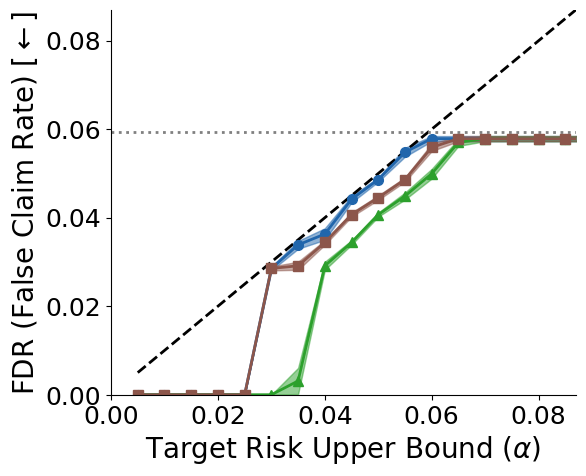

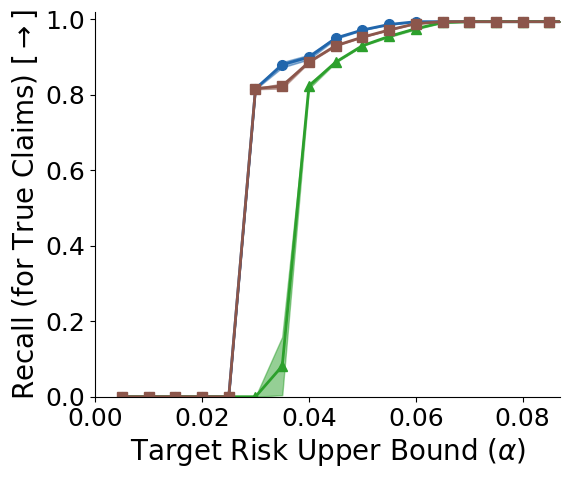

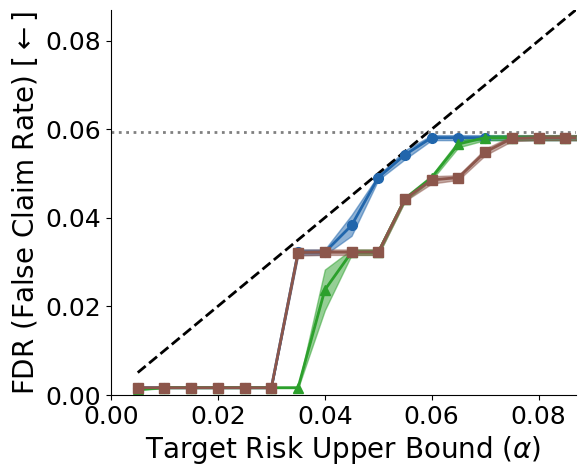

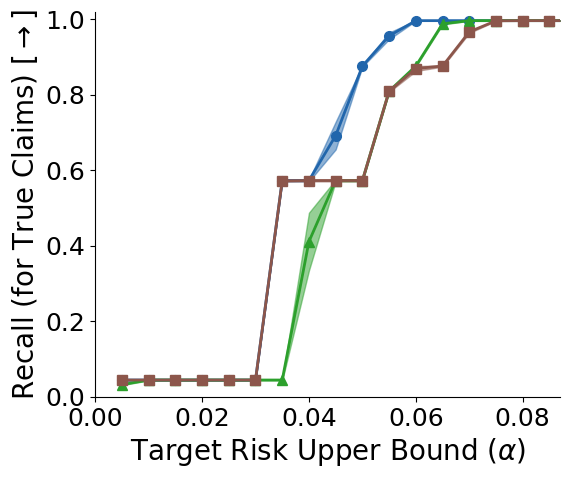

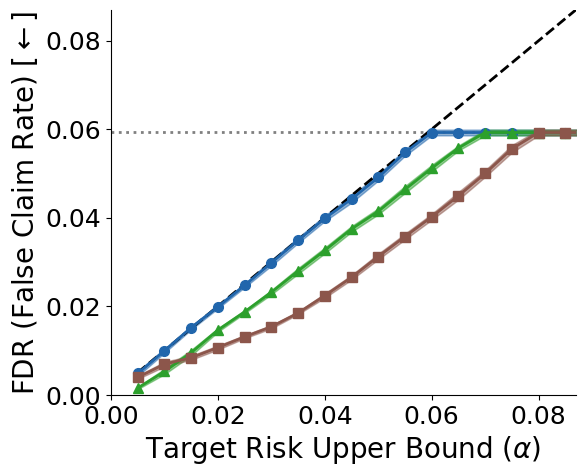

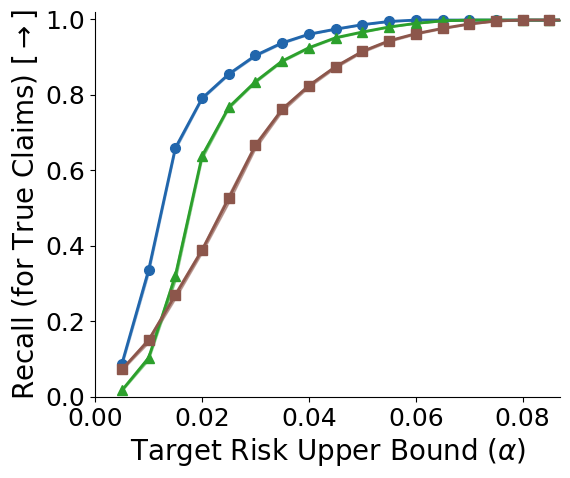

In [28]:
import matplotlib.transforms as mtransforms

import matplotlib.patches as patches





## Calculate population average fraction of unfactual subclaims
losses = np.zeros(len(annotations_arr))
for i, a in enumerate(annotations_arr):
    losses[i] = np.mean(1-a)
pop_avg_frac_unfactual = losses.mean()


## Plotting from loading
score_names = ["frequency", "selfevals", "logprobs"] #"frequency", "selfevals", "logprobs"
n_trials = 10
loss_name = "loss_factuality_fraction" #"loss_factuality_fraction"
method_names = ["gcrc", "ltt", "monotized_losses_crc"] # "standard_crc", "gcrc", "monotized_losses_crc", "monotized_losses_crc", "ltt",
ngrid = 200

for s_i, score_name in enumerate(score_names): #frequencies_arr, selfevals_arr, 

    results_df = pd.read_csv(f'/home/drewprinster/conformal-safety/notebooks/{loss_name}Loss_{score_name}Scoring_{n_trials}trials_{ngrid}ngrid_v2.csv')

    # display(results_df)
    # print(results_df.columns)
    
    method_name_map = {'gcrc' : 'GCRC (proposed)', 
                       'monotized_losses_crc' : 'Monotized-losses CRC (Mohri & Hashimoto, 2024; Angelopoulos et al., 2024)',
                       'standard_crc' : 'standard CRC (Angelopoulos, et al., 2024)',
                       'ltt' : 'LTT (Angelopoulos, et al., 2025)'}
    
    colors_dict = {'gcrc' : BLUE, 'monotized_losses_crc' : 'C5', 'ltt' : 'C2', 'standard_crc' : 'C1'}
    markers_dict = {'gcrc' : 'o', 'monotized_losses_crc' : 's', 'ltt' : '^', 'standard_crc' : 'X'}

    axlabelsize=20
    ticklabelsize=18
    plt.rc("axes.spines", top=False, right=False)
    markersize=7
    linewidth=2

                   
    for metric in ['risk', 'claims']:
        fig, ax = plt.subplots(figsize=(6, 5))
        alphas = results_df['alphas']
        
        # metric_dict = eval(f'{metric}_dict')
        if metric == 'risk':
            ax.plot(alphas, alphas, linestyle='--', color='black', label='Target Risk Upper Bound', linewidth=linewidth)
            ax.axhline(pop_avg_frac_unfactual, color='gray', label='Population Avg. Risk', linestyle=':', linewidth=linewidth)
            ax.set_ylabel(r'FDR (False Claim Rate) [$\leftarrow$]', fontsize=axlabelsize)
        else:
            ax.set_ylabel(r'Recall (for True Claims) [$\rightarrow$]', fontsize=axlabelsize)
            
        for m, method_name in enumerate(method_names):
            
            metric_mean = results_df[f'{method_name}_{metric}_mean']
            metric_std = results_df[f'{method_name}_{metric}_std']

            
            ax.fill_between(alphas, metric_mean - metric_std / np.sqrt(n_trials), metric_mean + metric_std / np.sqrt(n_trials), color=colors_dict[method_name], alpha = 0.5)
            ax.plot(alphas, metric_mean,  marker=markers_dict[method_name], label = method_name_map[method_name], color=colors_dict[method_name], markersize=markersize,linewidth=linewidth)
        
        ax.tick_params(axis='both', which='major', labelsize=ticklabelsize)
        ax.set_xlabel(r'Target Risk Upper Bound ($\alpha$)', fontsize=axlabelsize)
        ax.set_xlim([0.0, 0.087])
        if metric == 'risk':
            ax.set_ylim([0.0, 0.087])
        else:
            ax.set_ylim([0.0, 1.02])
        fig.savefig(f'{loss_name}Loss_{score_names[s_i]}Scoring_{metric}_{n_trials}trials_{ngrid}ngrid.pdf', bbox_inches='tight', dpi=300)

        

        if metric == 'risk':
            ## Save legend
            handles, labels = ax.get_legend_handles_labels()
            print(labels)
            leg1 = ax.legend(handles[0:3], labels[0:3], loc='lower left', bbox_to_anchor=(0.5, 1.05), ncols=3, frameon=False)
            ax.add_artist(leg1)
            legend_extent1 = leg1.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
            leg1.set_in_layout(False)
            # fig.savefig(f'legend1_{score_name}_{metric}_v2.pdf', bbox_inches=legend_extent1, dpi=300)
        
            leg2 = ax.legend(handles[3:], labels[3:], loc='lower left', bbox_to_anchor=(0.5, 1.0), ncols=2, frameon=False)
            # ax.add_artist(leg2)
            # leg1.set_in_layout(False)
            leg2.set_in_layout(False)
            legend_extent2 = leg2.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
            union_bbox = mtransforms.Bbox.union([legend_extent1, legend_extent2])
            print(union_bbox.x0, union_bbox.y0, union_bbox.x1, union_bbox.y1)

            # Create a Rectangle patch
            # Set `facecolor='none'` to make the inside transparent
            # Set `edgecolor` and `linewidth` to customize the border
            # rect = patches.Rectangle((union_bbox.x0, union_bbox.y0), union_bbox.x1, union_bbox.y1, linewidth=2, edgecolor='black', facecolor='none')
            
            # Add the patch to the axes
            # ax.add_patch(rect)

            fig.savefig(f'legend_{score_name}_{metric}.pdf', bbox_inches=union_bbox, dpi=300)

        fig.show()

    # results_df.to_csv(f'{loss_name}Loss_{score_names[s_i]}Scoring_{metric}_{n_trials}trials_notebook.csv')



In [246]:
results_df

,Unnamed: 0,alphas,monotized_losses_crc_risk_mean,monotized_losses_crc_risk_std,ltt_risk_mean,ltt_risk_std,gcrc_risk_mean,gcrc_risk_std,monotized_losses_crc_claims_mean,monotized_losses_crc_claims_std,ltt_claims_mean,ltt_claims_std,gcrc_claims_mean,gcrc_claims_std
0,0,0.005,0.003947,0.001143,0.001526,0.000823,0.004798,0.001809,0.068881,0.006774,0.016113,0.004904,0.083299,0.016179
1,1,0.010,0.006908,0.001702,0.005254,0.001931,0.009950,0.001452,0.143555,0.020104,0.098430,0.016414,0.322245,0.026224
2,2,0.015,0.008361,0.001428,0.009513,0.002012,0.015156,0.001281,0.257953,0.027334,0.307457,0.041069,0.633686,0.015316
3,3,0.020,0.010666,0.001425,0.014620,0.001255,0.019889,0.001167,0.373413,0.022180,0.613272,0.023276,0.762875,0.007370
4,4,0.025,0.013102,0.001082,0.018744,0.000988,0.024716,0.001378,0.505713,0.035696,0.739395,0.010087,0.828104,0.007013
5,5,0.030,0.015363,0.001191,0.023167,0.001522,0.029818,0.002061,0.640523,0.024699,0.807812,0.008486,0.879048,0.007155
6,6,0.035,0.018483,0.000889,0.027967,0.002033,0.034914,0.001943,0.734067,0.017599,0.863521,0.007318,0.915582,0.006967
7,7,0.040,0.022401,0.001524,0.032613,0.002067,0.039862,0.001976,0.797052,0.013252,0.901047,0.006508,0.942338,0.004658
8,8,0.045,0.026530,0.001620,0.037460,0.002045,0.044228,0.002585,0.848275,0.010886,0.931145,0.005944,0.959370,0.004868
9,9,0.050,0.031226,0.001978,0.041440,0.002163,0.049092,0.002170,0.890392,0.008883,0.949360,0.004550,0.975327,0.002686


In [247]:
loss_factuality_fractionLoss_logprobsScoring_claims_1trials

a = np.array([1, 2])
b = np.array([3, -1])
np.minimum(1, b)

NameError: name 'loss_factuality_fractionLoss_logprobsScoring_claims_1trials' is not defined

In [ ]:
method_name_map = {'gcrc' : 'GCRC (proposed)', 
                       'monotized_losses_crc' : 'Monotized-losses CRC \n(Mohri & Hashimoto, 2024; \nAngelopoulos et al., 2024)',
                       'standard_crc' : 'standard CRC (Angelopoulos, et al., 2024)',
                       'ltt' : 'LTT (Angelopoulos, et al., 2025; \nZhengping, et al., 2025)'}
    
for metric in ['risk', 'claims']:
    metric_dict = eval(f'{metric}_dict')
    for m, method_name in enumerate(method_names):
        alphas = metric_dict[method_name]['alphas']
        metric_mean = metric_dict[method_name][f'{metric}_mean']
        metric_std = metric_dict[method_name][f'{metric}_std']
        plt.fill_between(alphas, metric_mean - metric_std / np.sqrt(n_trials), metric_mean + metric_std / np.sqrt(n_trials), color=f'C{m}', alpha = 0.5)
        plt.plot(alphas, metric_mean, marker='o', label = method_name_map[method_name], color=f'C{m}')
    if metric == 'risk':
        plt.plot(alphas, alphas, linestyle='--', color='black', label='Target Risk Upper Bound')
        plt.ylabel('Realized risk (portion of subclaims false)', fontsize=12)
    else:
        plt.ylabel('Informativeness (portion of subclaims retained)', fontsize=12)

    plt.xlabel('Target alpha (target risk upper bound)', fontsize=12)
    plt.legend()
    plt.savefig(f'{score_names[s_i]}_{metric}.pdf', dpi=200)
    plt.show()


In [ ]:
##monotized_losses_crc

n_trials = 50
# all_covs = np.zeros((n_trials, 1 + len(dataset_names)))
# all_claims = np.zeros((n_trials, 1 + len(dataset_names)))

all_violations = np.zeros(n_trials)
all_claims = np.zeros(n_trials)


rng = np.random.default_rng(seed=0)
k = 0
# quantile = 0.9
alpha = 0.01
epsilon = None #0.1


# frequencies_arr_jitter = [freq + rng.uniform(low=0, high=1e-3, size=freq.shape) for freq in frequencies_arr]
# rng = np.random.default_rng(seed=1)
# for trial in tqdm(range(n_trials)):
#     cov_result, claims_result = run_coverage_trial(frequencies_arr_jitter, annotations_arr, z_arr_dummies, rng, k, quantile)
#     all_covs[trial] = cov_result
#     all_claims[trial] = claims_result

frequencies_arr_jitter = [freq + rng.uniform(low=0, high=1e-3, size=freq.shape) for freq in frequencies_arr]
rng = np.random.default_rng(seed=1)
for trial in tqdm(range(n_trials)):

    constraint_violations, claim_perc = run_crc_trial(frequencies_arr_jitter, annotations_arr, z_arr_dummies, rng, method_name="monotized_losses_crc", alpha=alpha, epsilon=epsilon)
    # print(f"constraint_violations : {constraint_violations}")
    # print(f"claim_perc : {claim_perc}")
    all_violations[trial] = constraint_violations
    all_claims[trial] = claim_perc
    
print(np.mean(all_violations,axis=0))
print(np.mean(all_claims, axis=0))


In [ ]:
## run 50 trials of conformal factuality with frequency claim score

n_trials = 50
all_covs_mh = np.zeros((n_trials, 1 + len(dataset_names)))
all_claims_mh = np.zeros((n_trials, 1 + len(dataset_names)))

rng = np.random.default_rng(seed=0)
k = 0
quantile = 0.9

frequencies_arr_jitter = [freq + rng.uniform(low=0, high=1e-3, size=freq.shape) for freq in frequencies_arr]
rng = np.random.default_rng(seed=1)
for trial in tqdm(range(n_trials)):
    cov_result, claims_result = run_coverage_trial(frequencies_arr_jitter, annotations_arr, z_ones, rng, k, quantile)
    all_covs_mh[trial] = cov_result
    all_claims_mh[trial] = claims_result


In [ ]:
# Create a DataFrame for each method
names = ["Marginal"] + dataset_names
indices_to_plot = np.arange(len(names))

names = [names[i] for i in indices_to_plot]

df1 = pd.DataFrame(1 - all_covs_mh[:,indices_to_plot], columns=names)
df2 = pd.DataFrame(1 - all_covs[:,indices_to_plot], columns=names)

# Add a column to identify the method
df1['Method'] = 'Split Conformal'
df2['Method'] = 'Conditional Conformal'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted_cov = df.melt(id_vars='Method', var_name='Dataset', value_name='Miscoverage')

df1 = pd.DataFrame(all_claims_mh[:,indices_to_plot] * 100, columns=names)
df2 = pd.DataFrame(all_claims[:,indices_to_plot] * 100, columns=names)

# Add a column to identify the method
df1['Method'] = 'Split Conformal'
df2['Method'] = 'Conditional Conformal'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted_claim = df.melt(id_vars='Method', var_name='Dataset', value_name='% Claims Retained')

# Create the boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
plot_ = sns.boxplot(x='Dataset', y='Miscoverage', hue='Method', data=df_melted_cov, ax=ax1, legend=False)
ax1.axhline(0.1, color='red')
ax1.set_xlabel("")
ax1.set_ylabel("Miscoverage", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

sns.boxplot(x='Dataset', y='% Claims Retained', hue='Method', data=df_melted_claim, ax=ax2)
ax2.legend(title="", fontsize=14)
ax2.set_xlabel("")
# ax2.axhline(80, color='red')
ax2.set_ylabel("% Claims Retained", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
# Customize the plot
# plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("figures/medlfqa_claim_cov_comparison.pdf")

## level-adaptive CP with frequency claim score

Scroll down further to get to see the boosting example + level-adaptive CP

In [ ]:
## now I should try to estimate the alpha at which the conditional conformal method retains 70% of the claims
rng = np.random.default_rng(seed=0)
k = 0

dataset = (frequencies_arr_jitter, annotations_arr)
# split dataset
data_alpha, data_conf, ind_alpha, ind_conf = split_dataset(dataset, rng, train_frac=0.1)


phi_alpha = lambda x: x 

# use data alpha to estimate critical alpha for which fact retention goal is achieved
data_calib, data_test, ind_calib, ind_test = split_dataset(data_alpha, rng, train_frac=0.5)
z_calib = z_arr[ind_calib]
z_test = z_arr[ind_test]

scores_calib = score_func(*data_calib, method=k)

x_test, y_test = data_test
n_grid = 50
percents = np.empty((n_grid, len(x_test)))

condconf = CondConf(lambda x,y: y, phi_alpha)
condconf.setup_problem(z_calib, scores_calib)

quantile_grid = np.linspace(0.01, 0.99, 50)
i = 0
for q in tqdm(quantile_grid):
    perc_q = []
    for x_t, z_t in zip(x_test, z_test):
        cutoff = condconf.predict(quantile=q, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=False)
        perc_q.append(get_retained_claims([x_t], cutoff)[0])
    percents[i] = perc_q
    i += 1 


perc_booleans = percents >= 0.5

first_violating_indices = np.argmax(~perc_booleans, axis=0) - 1
first_violating_indices[~np.any(~perc_booleans, axis=0)] = -1  # Use -1 to indicate no False found

max_quantiles = quantile_grid[first_violating_indices]

In [ ]:
condconf_alpha = CondConf(score_fn = lambda x, y: y, Phi_fn = phi_alpha)
condconf_alpha.setup_problem(z_test, max_quantiles)
_, primals = condconf_alpha._get_calibration_solution(quantile=0.05)

quantile_fn = lambda x: np.clip(phi_alpha(x) @ primals, a_min=0.01, a_max=0.99)
z_to_plot = phi_alpha(z_test)[:,-2] 

sorted_ind = np.argsort(z_to_plot)

plt.plot(z_to_plot[sorted_ind],1 - quantile_fn(z_test)[sorted_ind], color='black', linewidth=3)
print(quantile_fn(z_test).shape, max_quantiles.shape)
plt.scatter(z_to_plot, 1 - max_quantiles, alpha=0.2)
plt.xlabel("Plotted Conditional Covariate", fontsize=14)
plt.ylabel(r"$\alpha^*$", fontsize=14)
plt.show()

In [ ]:
seed = 1
k = 0
nominal = []
realized = []
percents = []
zs = []

realized_b = []
percents_b = []

def bin_fn(x, left, right):
    indics = (x <= right) & (x >= left)
    return indics.astype(np.float32)

## function class we calibrate against is called Phi_fn
for seed in tqdm(range(500)):
    rng = np.random.default_rng(seed=seed)
    
    data_calib, data_test, ind_calib, ind_test = split_dataset(data_conf, rng, train_frac=0.06)
    ind_test = ind_test[0:1000]
    z_calib = z_arr[ind_calib]
    z_test = z_arr[ind_test]
    
    x_calib, y_calib = data_calib
    scores_calib = score_func(*data_calib, method=k)
    score_fn = lambda x, y: y
    phi_fn = lambda x : np.concatenate(
        (x, (quantile_fn(x).reshape(-1,1) - 0.85)**2), 
        axis=1)

    condconf = CondConf(score_fn = score_fn, Phi_fn = phi_fn, quantile_fn = quantile_fn)
    condconf.setup_problem(z_calib, scores_calib)

    condconf_b = CondConf(score_fn = score_fn, Phi_fn = lambda x : np.ones((len(x), 1)))
    condconf_b.setup_problem(z_calib, scores_calib)

    quantiles_calib = quantile_fn(z_calib)
    
    x_test, y_test = data_test
    scores_test = score_func(*data_test, method=k)
    percs = []
    percs_b = []
    thresholds = []
    thresholds_b = []
    for x_t, z_t, s_t in zip(x_test, z_test, scores_test):
        try:
            threshold = condconf.predict(quantile=None, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except ValueError as e:
            threshold = [np.inf]
        try:
            threshold_b = condconf_b.predict(quantile=0.9, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except:
            threshold_b = [np.inf]
        percs.append(get_retained_claims([x_t], threshold)[0])
        thresholds.append(threshold)
        percs_b.append(get_retained_claims([x_t], threshold_b)[0])
        thresholds_b.append(threshold_b)
    realized.append([s <= t for s, t in zip(scores_test, thresholds)])
    percents.extend(percs)
    realized_b.append([s <= t for s, t in zip(scores_test, thresholds_b)])
    percents_b.extend(percs_b)
    
    zs.append(z_test)
    nominal.append(condconf.quantile_fn(z_test))

In [ ]:
num_bins = 13

nominal_avgs = np.zeros((len(nominal), num_bins))
realized_avgs = np.zeros((len(realized), num_bins))

for i, (n, r, r_b) in enumerate(zip(nominal, realized, realized_b)):
    realized_avg = []
    nominal_avg = []
    n = np.asarray(n)
    r = np.asarray(r)
    for bin_left in np.linspace(0.6, .85, 13):
        ind = np.where((n >= bin_left) & (n <= bin_left + 0.025))[0]
        nominal_avg.append(bin_left + 0.0125)
        realized_avg.append(r[ind].mean())
    nominal_avgs[i] = nominal_avg
    realized_avgs[i] = realized_avg

plt.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 
             1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[1]))
plt.plot(np.linspace(0.6, 0.875, 100), np.linspace(0.6, 0.875, 100), '--')
plt.show()

In [ ]:
zs_concat = quantile_fn(np.asarray(zs).reshape(-1, 5)).flatten()   
zs_concat = np.asarray(zs).reshape(-1,5)[:,1].flatten()

# Function to compute the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 5000
sorted_ind = np.argsort(zs_concat)
sorted_percents = np.asarray(percents)[sorted_ind]
sorted_percents_b = np.asarray(percents_b)[sorted_ind]

sorted_zs = zs_concat[sorted_ind]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[1]))
ax1.plot(np.linspace(0.6, 0.875, 100), np.linspace(0.6, 0.875, 100), '--', color='grey')
ax1.set_xlabel("Nominal level", fontsize=14)
ax1.set_ylabel("Realized level", fontsize=14)

ax2.plot(sorted_zs[window_size - 1:], 
         moving_average(100 * sorted_percents_b, window_size), label="Conformal Factuality")
ax2.plot(sorted_zs[window_size - 1:], 
         moving_average(100 * sorted_percents, window_size), label="Adaptive Level")

ax2.axhline(50, color='red')
ax2.set_xlabel("Response length", fontsize=14)
ax2.set_ylabel("% Claims Retained", fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig("figures/medlfqa_claim_calibration_retention.pdf")

In [13]:
# need to boost now...
# features to boost on: logprobs_arr, selfevals_arr, ordinals_arr

import torch
from scipy.optimize import linprog

def get_current_basis(primals, duals, Phi, S, quantile):
    interp_bools = np.logical_and(~np.isclose(duals, quantile - 1),~np.isclose(duals, quantile))
    if np.sum(interp_bools) == Phi.shape[1]:
        return interp_bools
    preds = (Phi @ primals).flatten()
    active_indices = np.where(interp_bools)[0]
    interp_indices = np.argsort(np.abs(S - preds))[0:Phi.shape[1]]
    diff_indices = np.setdiff1d(interp_indices, active_indices)
    num_missing = Phi.shape[1] - np.sum(interp_bools)
    if num_missing < len(diff_indices):
        from itertools import combinations
        for cand_indices in combinations(diff_indices, num_missing):
            cand_phi = Phi[np.concatenate((active_indices, cand_indices))]
            if np.isfinite(np.linalg.cond(cand_phi)):
                interp_bools[np.asarray(cand_indices)] = True
                break
    else:
        interp_bools[diff_indices] = True
    return interp_bools
            
def solve_qr(Phi, s, q, dtype):
    S = s.detach().numpy()
    zeros = np.zeros((Phi.shape[1],))
    bounds = [(q - 1, q)] * len(S)
    res = linprog(-1 * S, A_eq=Phi.T, b_eq=zeros, bounds=bounds,
                    method='highs-ds', options={'presolve': False})

    tau = -1 * res.eqlin.marginals

    basis = get_current_basis(tau, res.x, Phi, S, q)
    
    tau = as_tensor(np.linalg.inv(Phi[basis].T @ Phi[basis]) @ Phi[basis].T, dtype=dtype) @ s[basis]
    return tau.reshape(-1,1)

def as_tensor(x, dtype, requires_grad=False):
    return torch.tensor(x, dtype=dtype, requires_grad=requires_grad)
    
def cond_score_length(beta, dataset, z, rng, q=0.9):
    data_train, data_calib, ind_train, ind_calib = split_dataset(dataset, rng)
    x_train, y_train = data_train
    x_calib, y_calib = data_calib

    z_train = z[ind_train]
    z_calib = z[ind_calib]
    
    scores_train = torch_score_func(x_train, y_train, beta, method=0)

    Phi_fn = lambda x : x

    # scores_aug = torch.cat((scores_train, torch.tensor([1e5])))
    # cutoffs = torch.zeros((len(z_calib),), dtype=beta.dtype)
    # for i, z_c in enumerate(z_calib):
    #     z_aug = np.concatenate((z_train, z_c.reshape(1,-1)), axis=0)
    #     try:
    #         tau = solve_qr(z_aug, scores_aug, q, beta.dtype)
    #     except:
    #         print("gradient broke")
    #         tau = torch.zeros((len(z_c),), dtype=beta.dtype)
    #     cutoffs[i] = as_tensor(z_c, dtype=beta.dtype) @ tau
    
    # replace cutoff computation with quantile regression
    phi_train = Phi_fn(z_train)
    try:
        tau = solve_qr(phi_train, scores_train, q, beta.dtype)
    except:
        tau = torch.zeros((phi_train.shape[1],), dtype=beta.dtype)

    phi_calib = Phi_fn(z_calib)
    cutoffs = torch.flatten(as_tensor(phi_calib, dtype=beta.dtype) @ tau)

    total = torch.zeros(1, requires_grad=True)
    for x_c, cutoff in zip(x_calib, cutoffs):
        perc = torch.sigmoid((cutoff - torch.abs(torch.as_tensor(x_c, dtype=beta.dtype) @ beta)))
        total = total + torch.mean(perc) / len(cutoffs)

    return total, (x_calib, cutoffs), tau

def torch_score_func(features, annotations, beta, method):
    scores = as_tensor(np.zeros((len(features),)), dtype=beta.dtype)
    for i, (f, a) in enumerate(zip(features, annotations)):
        cs = torch.abs(as_tensor(f, dtype=beta.dtype) @ beta)
        at = as_tensor(a, dtype=bool)
        scores[i] = torch.sort(cs[~at], descending=True)[0][method] if torch.sum(~at) > method else -1
    return scores
    
rng = np.random.default_rng(seed=0)
features_arr = [np.concatenate((f_arr.reshape(-1,1), s_arr.reshape(-1,1), l_arr.reshape(-1,1) / l_arr.max(),
                               o_arr.reshape(-1,1)), axis=1)
                for f_arr, s_arr, l_arr, o_arr in zip(frequencies_arr, selfevals_arr, logprobs_arr, ordinal_arr)]

dataset = (features_arr, annotations_arr)
# split dataset
data_alpha, data_conf, ind_alpha, ind_conf = split_dataset(dataset, rng, train_frac=0.3)
z_alpha = z_arr_dummies[ind_alpha]

beta_cond = torch.tensor(np.asarray([0.25,0.25,0.25,0.25]), dtype=torch.float, requires_grad=True)

print(beta_cond)
optimizer = torch.optim.Adam([beta_cond])

obj_percs = []
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    perc, (x_calib, cutoffs), tau = cond_score_length(beta_cond, data_alpha, z_alpha, rng)
    perc.backward()
    optimizer.step()
    obj_percs.append(perc.detach())
    if i % 100 == 0:
        print(obj_percs[-1], beta_cond, beta_cond.grad)
print(beta_cond, perc)

tensor([0.2500, 0.2500, 0.2500, 0.2500], requires_grad=True)


  0%|                                                                               | 1/1000 [00:00<03:25,  4.86it/s]

tensor([0.6597]) tensor([0.2510, 0.2510, 0.2510, 0.2490], requires_grad=True) tensor([-0.0704, -0.0021, -0.0047,  0.3489])


 10%|███████▊                                                                     | 102/1000 [00:18<02:38,  5.67it/s]

tensor([0.6363]) tensor([0.3170, 0.2786, 0.2838, 0.1424], requires_grad=True) tensor([-0.1002, -0.0111, -0.0074,  0.7975])


 20%|███████████████▌                                                             | 202/1000 [00:34<01:55,  6.91it/s]

tensor([0.5170]) tensor([0.3699, 0.2998, 0.2968, 0.0147], requires_grad=True) tensor([-0.0133,  0.0067, -0.0019,  1.2338])


 30%|███████████████████████▎                                                     | 302/1000 [00:49<01:41,  6.85it/s]

tensor([0.5104]) tensor([0.3414, 0.2878, 0.2836, 0.0037], requires_grad=True) tensor([ 0.0248, -0.0044,  0.0064,  0.2791])


 40%|██████████████████████████████▉                                              | 402/1000 [01:03<01:26,  6.91it/s]

tensor([0.5095]) tensor([0.3006, 0.2861, 0.2626, 0.0064], requires_grad=True) tensor([ 0.0274, -0.0117,  0.0063,  0.4054])


 50%|██████████████████████████████████████▋                                      | 502/1000 [01:18<01:11,  6.95it/s]

tensor([0.5079]) tensor([0.2561, 0.2834, 0.2406, 0.0045], requires_grad=True) tensor([ 0.0281,  0.0014,  0.0080, -0.4384])


 60%|██████████████████████████████████████████████▎                              | 602/1000 [01:32<00:57,  6.91it/s]

tensor([0.5084]) tensor([ 0.2058,  0.2728,  0.2151, -0.0038], requires_grad=True) tensor([ 0.0167,  0.0082,  0.0105, -0.0925])


 70%|██████████████████████████████████████████████████████                       | 702/1000 [01:46<00:42,  7.05it/s]

tensor([0.5066]) tensor([0.1702, 0.2755, 0.2029, 0.0032], requires_grad=True) tensor([ 0.0245, -0.0035,  0.0085,  0.5062])


 80%|█████████████████████████████████████████████████████████████▊               | 802/1000 [02:01<00:28,  6.95it/s]

tensor([0.5055]) tensor([0.1331, 0.2568, 0.1777, 0.0022], requires_grad=True) tensor([ 2.8928e-02, -5.5401e-03, -1.3531e-04,  1.1576e+00])


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [02:16<00:14,  6.86it/s]

tensor([0.5037]) tensor([0.0905, 0.2277, 0.1459, 0.0024], requires_grad=True) tensor([ 0.0147, -0.0118,  0.0065,  1.6270])


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:30<00:00,  6.63it/s]

tensor([0.0461, 0.1889, 0.1142, 0.0008], requires_grad=True) tensor([0.5026], grad_fn=<AddBackward0>)


In [ ]:
scores_arr_alpha = [f @ beta_cond.detach().numpy() for f in data_alpha[0]]
scores_arr_conf = [f @ beta_cond.detach().numpy() for f in data_conf[0]]

window_size = 10
plt.plot(np.arange(len(obj_percs))[window_size - 1:], moving_average(np.asarray(obj_percs).flatten(), window_size))
plt.show()

In [ ]:
n_trials = 50
all_covs_jc = np.zeros((n_trials, 1 + len(dataset_names)))
all_claims_jc = np.zeros((n_trials, 1 + len(dataset_names)))

rng = np.random.default_rng(seed=0)
k = 0
quantile = 0.9

scores_arr_alpha = [score + rng.uniform(low=0, high=1e-3, size=score.shape) for score in scores_arr_alpha]
scores_arr_jitter = [score + rng.uniform(low=0, high=1e-3, size=score.shape) for score in scores_arr_conf]
rng = np.random.default_rng(seed=1)
for trial in tqdm(range(n_trials)):
    cov_result, claims_result = run_coverage_trial(scores_arr_jitter, data_conf[1], z_arr_dummies[ind_conf], rng, k, quantile)
    all_covs_jc[trial] = cov_result
    all_claims_jc[trial] = claims_result

 32%|█████████████████████████▌                                                      | 16/50 [00:22<00:51,  1.50s/it]

In [ ]:
# Create a DataFrame for each method
names = ["Marginal"] + dataset_names
indices_to_plot = np.arange(len(names))

names = [names[i] for i in indices_to_plot]
df1 = pd.DataFrame(all_claims_jc[:,indices_to_plot] * 100, columns=names)
df2 = pd.DataFrame(all_claims[:,indices_to_plot] * 100, columns=names)

# Add a column to identify the method
df1['Method'] = 'Boosted Conditional Conformal'
df2['Method'] = 'Conditional Conformal'

# Combine the DataFrames
df = pd.concat([df1, df2])

# Melt the combined DataFrame
df_melted = df.melt(id_vars='Method', var_name='Dataset', value_name='% Claims Retained')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dataset', y='% Claims Retained', hue='Method', data=df_melted)
# Customize the plot
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig('figures/medlfqa_boosting.pdf')
print(np.mean(all_claims_jc[:,0]), np.mean(all_claims[:,0]))

In [14]:
## now I should try to estimate the alpha at which the conditional conformal method retains 70% of the claims

def index_dataset(dataset, ind):
    x_vals = [dataset[0][i] for i in ind]
    y_vals = [dataset[1][i] for i in ind]
    return (x_vals, y_vals)
    
rng = np.random.default_rng(seed=0)
k = 0

data_alpha = (scores_arr_alpha, data_alpha[1])
data_conf = (scores_arr_jitter, data_conf[1])

dataset_b = (frequencies_arr_jitter, annotations_arr)
# split dataset
data_conf_b = index_dataset(dataset_b, ind_conf)

phi_alpha = lambda x: x 

# use data alpha to estimate critical alpha for which fact retention goal is achieved
data_calib, data_test, ind_calib, ind_test = split_dataset(data_alpha, rng, train_frac=0.5)
ind_calib = ind_alpha[ind_calib]
ind_test = ind_alpha[ind_test]
z_calib = z_arr_dummies[ind_calib]
z_test = z_arr_dummies[ind_test]

scores_calib = score_func(*data_calib, method=k)

scores_calib += rng.uniform(0, 1e-5, size=(len(scores_calib),))

x_test, y_test = data_test
n_grid = 50
percents = np.empty((n_grid, len(x_test)))

condconf = CondConf(lambda x,y: y, phi_alpha)
condconf.setup_problem(z_calib, scores_calib)

quantile_grid = np.linspace(0.20, 0.99, 50)
i = 0
for q in tqdm(quantile_grid):
    perc_q = []
    for x_t, z_t in zip(x_test, z_test):
        try:
            cutoff = condconf.predict(quantile=q, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=False)
        except ValueError as e:
            print("dataset too small probably")
            raise ValueError(e)
            cutoff = [np.inf]
        perc_q.append(get_retained_claims([x_t], cutoff)[0])
    percents[i] = perc_q
    i += 1 


perc_booleans = percents >= 0.7

first_violating_indices = np.argmax(~perc_booleans, axis=0) - 1
first_violating_indices[~np.any(~perc_booleans, axis=0)] = -1  # Use -1 to indicate no False found

max_quantiles = quantile_grid[first_violating_indices]

NameError: name 'scores_arr_alpha' is not defined

In [ ]:
phi_alpha_fun = lambda x : x#x[:, :-4]
condconf_alpha = CondConf(score_fn = lambda x, y: y, Phi_fn = phi_alpha_fun)
condconf_alpha.setup_problem(z_test, max_quantiles)

q = 5
_, primals = condconf_alpha._get_calibration_solution(quantile=q/100)
quantile_fn = lambda x: np.clip(phi_alpha_fun(x) @ primals, a_min=0.5, a_max=0.99)
z_to_plot = phi_alpha(z_test)[:,-5] 

sorted_ind = np.argsort(z_to_plot)

plt.figure()
plt.hist(quantile_fn(z_test)[sorted_ind])
plt.show()

In [ ]:
seed = 1
k = 0
n_seeds = 100
nominal = []
realized = []
percents = []
zs = []

realized_jc = []
percents_jc = []

realized_b = []
percents_b = []

dataset_covs = np.zeros((n_seeds, len(dataset_names)))
dataset_claims = np.zeros((n_seeds, len(dataset_names)))

dataset_covs_jc = np.zeros((n_seeds, len(dataset_names)))
dataset_claims_jc = np.zeros((n_seeds, len(dataset_names)))

dataset_covs_b = np.zeros((n_seeds, len(dataset_names)))
dataset_claims_b = np.zeros((n_seeds, len(dataset_names)))

def bin_fn(x, left, right):
    indics = (x <= right) & (x >= left)
    return indics.astype(np.float32)

for seed in tqdm(range(n_seeds)):
    rng = np.random.default_rng(seed=seed)
    
    data_calib, data_test, ind_calib, ind_test = split_dataset(data_conf, rng, train_frac=0.7) # used to be 0.06
    data_calib_b = index_dataset(data_conf_b, ind_calib)
    data_test_b = index_dataset(data_conf_b, ind_test)

    ind_calib = ind_conf[ind_calib]
    ind_test = ind_conf[ind_test]
    
    ind_test = ind_test[0:500]
    z_calib = z_arr_dummies[ind_calib]
    z_test = z_arr_dummies[ind_test]
    dataset_dummies_test = dataset_dummies.to_numpy()[ind_test]
    
    x_calib, y_calib = data_calib
    scores_calib = score_func(*data_calib, method=k)
    scores_calib_b = score_func(*data_calib_b, method=k)
    
    score_fn = lambda x, y: y
    phi_fn_jc = lambda x : x
    
    quantile_bins = np.linspace(0.5, 1.0, 11)
    active_quantiles = quantile_fn(z_calib).flatten()

    active_bins = []
    for q_lower, q_upper in zip(quantile_bins, quantile_bins[1:]):
        inds = np.where((active_quantiles <= q_upper) & (active_quantiles >= q_lower))[0]
        if len(inds) > 5:
            active_bins.append((q_lower, q_upper))

    phi_fn = lambda x: np.concatenate(
        (
            x,
            # quantile_fn(x)**2,
            # quantile_fn(x)**3
            *(bin_fn(quantile_fn(x), b[0], b[1]).reshape(-1,1) for b in active_bins)
        ),
        axis=1
    )

    condconf = CondConf(score_fn = score_fn, Phi_fn = phi_fn, quantile_fn = quantile_fn)
    condconf.setup_problem(z_calib, scores_calib)

    condconf_jc = CondConf(score_fn = score_fn, Phi_fn = phi_fn_jc, quantile_fn = quantile_fn)
    condconf_jc.setup_problem(z_calib, scores_calib)

    condconf_b = CondConf(score_fn = score_fn, Phi_fn = lambda x : np.ones((len(x), 1)))
    condconf_b.setup_problem(z_calib, scores_calib_b)

    quantiles_calib = quantile_fn(z_calib)
    
    x_test, y_test = data_test
    x_test_b, y_test_b = data_test_b
    scores_test = score_func(*data_test, method=k)
    scores_test_b = score_func(*data_test_b, method=k)
    percs = []
    percs_jc = []
    percs_b = []
    thresholds = []
    thresholds_jc = []
    thresholds_b = []
    for x_t, z_t, s_t, xb_t in zip(x_test, z_test, scores_test, x_test_b):
        try:
            threshold = condconf.predict(quantile=None, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except ValueError as e:
            raise ValueError(e)
            threshold = [np.inf]
            
        try:
            threshold_jc = condconf_jc.predict(quantile=0.9, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except:
            threshold_jc = [np.inf]
            
        try:
            threshold_b = condconf_b.predict(quantile=0.9, x_test=z_t.reshape(1,-1), score_inv_fn = lambda c, x: c, randomize=True)
        except:
            threshold_b = [np.inf]
        percs.append(get_retained_claims([x_t], threshold)[0])
        thresholds.append(threshold)
        percs_jc.append(get_retained_claims([x_t], threshold_jc)[0])
        thresholds_jc.append(threshold_jc)
        percs_b.append(get_retained_claims([xb_t], threshold_b)[0])
        thresholds_b.append(threshold_b)
    realized.append([s <= t for s, t in zip(scores_test, thresholds)])
    percents.extend(percs)
    realized_jc.append([s <= t for s, t in zip(scores_test, thresholds_jc)])
    percents_jc.extend(percs_jc)
    realized_b.append([s <= t for s, t in zip(scores_test_b, thresholds_b)])
    percents_b.extend(percs_b)
    
    zs.append(z_test)
    nominal.append(condconf.quantile_fn(z_test))

    for d_idx in range(len(dataset_names)):
        dataset_cov = np.sum(dataset_dummies_test[:,d_idx] * np.asarray(realized[-1]).flatten()) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_covs[seed,d_idx] = dataset_cov
        dataset_perc = np.sum(dataset_dummies_test[:,d_idx] * percs) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_claims[seed,d_idx] = dataset_perc

    for d_idx in range(len(dataset_names)):
        dataset_cov = np.sum(dataset_dummies_test[:,d_idx] * np.asarray(realized_b[-1]).flatten()) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_covs_b[seed,d_idx] = dataset_cov
        dataset_perc = np.sum(dataset_dummies_test[:,d_idx] * percs_b) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_claims_b[seed,d_idx] = dataset_perc
        
    for d_idx in range(len(dataset_names)):
        dataset_cov = np.sum(dataset_dummies_test[:,d_idx] * np.asarray(realized_jc[-1]).flatten()) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_covs_jc[seed,d_idx] = dataset_cov
        dataset_perc = np.sum(dataset_dummies_test[:,d_idx] * percs_jc) / np.sum(dataset_dummies_test[:,d_idx])
        dataset_claims_jc[seed,d_idx] = dataset_perc

In [ ]:
group_nominal_avgs = np.zeros((2, len(nominal), len(active_bins)))
group_realized_avgs = np.zeros((2, len(nominal), len(active_bins)))

for i in tqdm(range(n_seeds)):
    rng = np.random.default_rng(seed=i)
    
    data_calib, data_test, ind_calib, ind_test = split_dataset(data_conf, rng, train_frac=0.7) # used to be 0.06
    data_calib_b = index_dataset(data_conf_b, ind_calib)
    data_test_b = index_dataset(data_conf_b, ind_test)

    ind_calib = ind_conf[ind_calib]
    ind_test = ind_conf[ind_test]
    
    ind_test = ind_test[0:500]
    z_calib = z_arr_dummies[ind_calib]
    z_test = z_arr_dummies[ind_test]
    dataset_dummies_test = dataset_dummies.to_numpy()[ind_test]

    for j, d_idx in enumerate([0,2]):
        n = nominal[i][dataset_dummies_test[:,d_idx]]
        r = np.asarray(realized[i])[dataset_dummies_test[:,d_idx]]
        realized_avg = []
        nominal_avg = []
        for bin_left, bin_right in active_bins:
            ind = np.where((n >= bin_left) & (n <= bin_right))[0]
            nominal_avg.append((bin_left + bin_right)/2)
            realized_avg.append(r[ind].mean())
        group_nominal_avgs[j, i, :] = nominal_avg
        group_realized_avgs[j, i, :] = realized_avg

for name, nominal_avgs, realized_avgs in zip(dataset_names, group_nominal_avgs, group_realized_avgs):
    print(np.mean(nominal_avgs, axis=0) - np.mean(realized_avgs, axis=0))
    plt.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 
                 1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[0]), label=name)
    plt.plot(np.linspace(0.5, 0.85, 100), np.linspace(0.5, 0.85, 100), '--', color='grey')
    # plt.set_xlabel("Nominal level", fontsize=14)
    # plt.set_ylabel("Realized level", fontsize=14)
plt.legend()
plt.show()
print(0.9 - dataset_covs_b.mean(axis=0))

In [ ]:
len(ind_conf), len(ind_calib), len(ind_test)

In [ ]:
num_bins = len(active_bins) + 1
z_dim = 9
nominal_avgs = np.zeros((len(nominal), num_bins - 1))
realized_avgs = np.zeros((len(realized), num_bins - 1))

for i, (n, r, r_b) in enumerate(zip(nominal, realized, realized_b)):
    realized_avg = []
    nominal_avg = []
    n = np.asarray(n)
    r = np.asarray(r)
    # bins = np.linspace(0.500, 0.9, num_bins)
    # for bin_left, bin_right in zip(bins, bins[1:]):
    #     ind = np.where((n >= bin_left) & (n <= bin_right))[0]
    #     nominal_avg.append((bin_left + bin_right)/2)
    #     realized_avg.append(r[ind].mean())
    for bin_left, bin_right in active_bins:
        ind = np.where((n >= bin_left) & (n <= bin_right))[0]
        nominal_avg.append((bin_left + bin_right)/2)
        realized_avg.append(r[ind].mean())
    nominal_avgs[i] = nominal_avg
    realized_avgs[i] = realized_avg


zs_concat = quantile_fn(np.asarray(zs).reshape(-1, z_dim)).flatten()   
zs_concat = np.asarray(zs).reshape(-1,z_dim)[:,1].flatten()
# zs_concat = quantile_fn(zs).flatten()

# Function to compute the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 5000
sorted_ind = np.argsort(zs_concat)
sorted_percents = np.asarray(percents)[sorted_ind]
sorted_percents_b = np.asarray(percents_b)[sorted_ind]

sorted_zs = zs_concat[sorted_ind]

# Extract bin edges from active_bins
all_bin_edges = []
for bin_left, bin_right in active_bins:
    all_bin_edges.extend([bin_left, bin_right])
bins = np.unique(all_bin_edges)

min_bin = np.min(bins) - 0.025
max_bin = np.max(bins) + 0.025

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 
             1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[0]))
ax1.plot(np.linspace(min_bin, max_bin, 100), np.linspace(min_bin, max_bin, 100), '--', color='grey')
ax1.set_xlabel("Nominal level", fontsize=14)
ax1.set_ylabel("Realized level", fontsize=14)

ax2.plot(sorted_zs[window_size - 1:], 
         moving_average(100 * sorted_percents_b, window_size), label="Conformal Factuality")
ax2.plot(sorted_zs[window_size - 1:], 
         moving_average(100 * sorted_percents, window_size), label="Adaptive Level")

ax2.axhline(50, color='red')
ax2.set_xlabel("Response length", fontsize=14)
ax2.set_ylabel("% Claims Retained", fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig("figures/medlfqa_claim_calibration_retention.pdf")
print(bins)

In [ ]:
print(realized_avgs.shape[1])
plt.figure(figsize=(15,6))
plt.boxplot([realized_avgs[:,i] for i in range(realized_avgs.shape[1])])
plt.plot(np.arange(1, 1 + (realized_avgs.shape[1])), [np.mean(realized_avgs[:,i]) for i in range(realized_avgs.shape[1])])
plt.plot(np.arange(1, 1 + (realized_avgs.shape[1])), [np.mean(nominal_avgs[:,i]) for i in range(realized_avgs.shape[1])])
plt.xticks(ticks=np.arange(1, 1 + realized_avgs.shape[1]), labels=[np.around(np.mean(nominal_avgs[:,i]), 3) for i in range(realized_avgs.shape[1])])
plt.tight_layout()
plt.show()

In [ ]:
# Create a DataFrame for each method
names = dataset_names
names = ["HealthSearchQA", "K-QA Golden", "K-QA Silver", "LiveQA", "MedicationQA"]
indices_to_plot = np.arange(len(names))

names = [names[i] for i in indices_to_plot]
df1 = pd.DataFrame(dataset_claims_b[:,indices_to_plot] * 100, columns=names)
df2 = pd.DataFrame(dataset_claims_jc[:,indices_to_plot] * 100, columns=names)
df3 = pd.DataFrame(dataset_claims[:,indices_to_plot] * 100, columns=names)

# Add a column to identify the method
df1['Method'] = 'Conformal Factuality'
df2['Method'] = 'Conditional Boosting'
df3['Method'] = 'Conditional Boosting + Level-Adaptive'

# Combine the DataFrames
df = pd.concat([df1, df2, df3])

# Melt the combined DataFrame
df_melted = df.melt(id_vars='Method', var_name='Dataset', value_name='% Claims Retained')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dataset', y='% Claims Retained', hue='Method', data=df_melted)
plt.axhline(70, color='red')

print(np.mean(dataset_claims_jc), np.mean(dataset_claims_b))

# Customize the plot
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig('figures/medlfqa_boosting.pdf')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[1,2])
ax1.errorbar(np.mean(nominal_avgs, axis=0), np.mean(realized_avgs, axis=0), 
             1.96 * np.std(realized_avgs, axis=0) / np.sqrt(realized_avgs.shape[0]), marker='o')
ax1.plot(np.linspace(0.50, 0.85, 100), np.linspace(0.50, 0.85, 100), '--', color='grey')
ax1.set_xlabel("Nominal level", fontsize=14)
ax1.set_ylabel("Realized level", fontsize=14)

sns.boxplot(x='Dataset', y='% Claims Retained', hue='Method', data=df_melted, ax=ax2)
ax2.axhline(70, color='red')
ax2.set_ylabel("% Claims Retained", fontsize=14)

# Customize the plot
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
# ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)
ax2.set_xlabel("Dataset", fontsize=14)
plt.tight_layout()
plt.show()
# plt.savefig("figures/medlfqa_intro_validity_final.pdf")
